# Object Detection Demo: City Network of Capture Points
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [12]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import getpass
import shutil

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from PIL import ImageGrab
import time
import pandas as pd

import cv2

import requests
from io import BytesIO

from copy import deepcopy

import scipy.misc

from datetime import datetime

import arcgis

## Env setup

In [13]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Establish Connection to ArcGIS Online via ArcGIS API for Python

#### Authenticate

In [14]:
portals_dict = {
    "esrifederal_gis": r"https://esrifederal.maps.arcgis.com",
    "natgov_gis": r"http://esri-natgov105.eastus.cloudapp.azure.com/arcgis",
    "dot_gis": r"http://dot.esri.com/portal",
    "dev_gis": r"http://govdev.eastus.cloudapp.azure.com/arcgis",
    "local_gis": r"https://anieto.esri.com/arcgis",
    "brett_gis": r"https://agsbase.dcwebgis.net/portal",
    "bill_gis": r"https://idt.esri.com/portal"
}

gis_url = portals_dict["esrifederal_gis"]

if gis_url == portals_dict["esrifederal_gis"]:
    gis_app_id = r"wt3QUR1M4eum0TVI"
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, client_id=gis_app_id)
    print("Successfully logged in as: " + gis.properties.user.username)
else:
    gis_username = getpass.getpass(prompt="Username: ")
    gis_pw = getpass.getpass(prompt="Password: ")
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, gis_username, gis_pw, verify_cert=False)
    print("Successfully logged in as: " + gis.properties.user.username)

Attempting to log in to 'https://esrifederal.maps.arcgis.com'...
Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://esrifederal.maps.arcgis.com/sharing/rest/oauth2/authorize?client_id=wt3QUR1M4eum0TVI&response_type=code&expiration=-1&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob
Enter code obtained on signing in using SAML: ········
Successfully logged in as: albe9057@esri.com_esrifederal


## Object detection imports
Here are the imports from the object detection module.

In [15]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

### Model: SSD Mobilenet on COCO

In [16]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Load a (frozen) Tensorflow model into memory.

In [17]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [18]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [19]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

This is a helper function that takes the detection graph output tensor (np arrays), stacks the classes and scores, and determines if the class for a person (1) is available within a certain score and within a certain amount of objects

In [20]:
def object_counter(classes_arr, scores_arr, score_thresh=0.5):
    # Process the numpy array of classes from the model
    stacked_arr = np.stack((classes_arr, scores_arr), axis=-1)
    # Convert to pandas dataframe for easier querying
    detection_df = pd.DataFrame(stacked_arr)
    # Retrieve total count of cars with score threshold above param value
    detected_cars = detection_df[(detection_df[0] == 3.0) & (detection_df[1] > score_thresh)]
    detected_people =  detection_df[(detection_df[0] == 1.0) & (detection_df[1] > score_thresh)]
    detected_bicycles =  detection_df[(detection_df[0] == 2.0) & (detection_df[1] > score_thresh)]
    detected_motorcycles =  detection_df[(detection_df[0] == 4.0) & (detection_df[1] > score_thresh)]
    detected_buses =  detection_df[(detection_df[0] == 6.0) & (detection_df[1] > score_thresh)]
    detected_trucks =  detection_df[(detection_df[0] == 8.0) & (detection_df[1] > score_thresh)]
    
    car_count = len(detected_cars)
    people_count = len(detected_people)
    bicycle_count = len(detected_bicycles)
    motorcycle_count = len(detected_motorcycles)
    bus_count = len(detected_buses)
    truck_count = len(detected_trucks)

    return car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count

def return_lat(row):
    return row['location']['latitude']

def return_lon(row):
    return row['location']['longitude']

# Network Camera Processing

In [21]:
# TrafficLand API source JSON
source_json = r"http://api.trafficland.com/v1.5/json/video_feeds?system=ddot&key=1594c8892d7fbd18181a8a6a44958b28"
df = pd.read_json(source_json)
ddot_df = df.loc[df.provider == 'DDOT']
# Edit the ddot_df to make a feature service using the API
ddot_df['latitude'] = ddot_df.apply(lambda row: return_lat(row), axis=1)
ddot_df['longitude'] = ddot_df.apply(lambda row: return_lon(row), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


# Multiple Camera Iteration Prototyping

In [22]:
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
jpeg_size = "halfJpeg" # Other Options: halfJpeg; fullJpeg; hugeJpeg

## P1: Use existing feature service and send model outputs as updates

OPS Service

<Item title:"DDOT Traffic Cameras (Firefly)" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
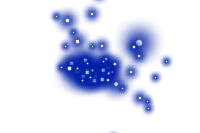

In [39]:
object_point_srvc = gis.content.search("DDOT Traffic Cameras", item_type="feature service")[1]
object_point_srvc

DEV Service

<Item title:"DDOT_TrafficCameras_CityNetwork" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
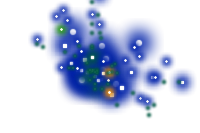

In [38]:
object_point_srvc = gis.content.search("DDOT_TrafficCameras_CityNetwork", item_type="feature service")[0]
object_point_srvc

In [40]:
# Convert our existing service into a pandas dataframe
object_point_lyr = object_point_srvc.layers[0]
obj_fset = object_point_lyr.query()  #querying without any conditions returns all the features
obj_df = obj_fset.df
all_features = obj_fset.features
original_feature = all_features[1]
feature_to_be_updated = deepcopy(original_feature)

#### Reset Routine

https://esrifederal.maps.arcgis.com/home/webmap/viewer.html?webmap=255196da558749209dc63c07ffb38ae6

In [52]:
for iteration in range(1):
    
    features_for_update = []
            
    for ix in range(1,111):
        print("Restting values for camera {0} of 100...".format(str(ix)))

        # Retrieve camera information
        camera_name = ddot_df.iloc[ix]['name']

        # Retrieve the feature from the feature layer to update
        obj_fset = object_point_lyr.query(where="""name = '"""+camera_name+"""'""", return_geometry=False)  
        all_features = obj_fset.features
        original_feature = all_features[0]
        feature_to_be_updated = deepcopy(original_feature)

        
        feature_to_be_updated.attributes['rt_object_count'] = 0
        feature_to_be_updated.attributes['rt_vehicle_count'] = 0
        feature_to_be_updated.attributes['rt_car_count'] = 0
        feature_to_be_updated.attributes['rt_bus_count'] = 0
        feature_to_be_updated.attributes['rt_truck_count'] = 0
        feature_to_be_updated.attributes['rt_motorcycle_count'] = 0
        feature_to_be_updated.attributes['rt_pedestrian_count'] = 0
        feature_to_be_updated.attributes['rt_bicycle_count'] = 0
        
        feature_to_be_updated.attributes['histval_10am_th_car'] = None
        feature_to_be_updated.attributes['histval_10am_th_ped'] = None
        feature_to_be_updated.attributes['histval_10am_th_bus'] = None
        feature_to_be_updated.attributes['histval_10am_th_trck'] = None

        features_for_update.append(feature_to_be_updated)
        
    object_point_lyr.edit_features(updates=features_for_update)   

Restting values for camera 1 of 100...
Restting values for camera 2 of 100...
Restting values for camera 3 of 100...
Restting values for camera 4 of 100...
Restting values for camera 5 of 100...
Restting values for camera 6 of 100...
Restting values for camera 7 of 100...
Restting values for camera 8 of 100...
Restting values for camera 9 of 100...
Restting values for camera 10 of 100...
Restting values for camera 11 of 100...
Restting values for camera 12 of 100...
Restting values for camera 13 of 100...
Restting values for camera 14 of 100...
Restting values for camera 15 of 100...
Restting values for camera 16 of 100...
Restting values for camera 17 of 100...
Restting values for camera 18 of 100...
Restting values for camera 19 of 100...
Restting values for camera 20 of 100...
Restting values for camera 21 of 100...
Restting values for camera 22 of 100...
Restting values for camera 23 of 100...
Restting values for camera 24 of 100...
Restting values for camera 25 of 100...
Restting 

## Model Update with Attachments

In [ ]:
overwrite_attachment = True

upload_source = False

with detection_graph.as_default():
    
    with tf.Session(graph=detection_graph) as sess:
        
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for iteration in range(10):
            # TrafficLand API source JSON
            source_json = r"http://api.trafficland.com/v1.5/json/video_feeds?system=ddot&key=1594c8892d7fbd18181a8a6a44958b28"
            df = pd.read_json(source_json)
            ddot_df = df.loc[df.provider == 'DDOT']
            
            for ix in range(1,110):
                print("Processing camera {0} of 110...".format(str(ix)))

                # Retrieve camera information
                camera_jpeg_url = ddot_df.iloc[ix]['content']['hugeJpeg']
                camera_name = ddot_df.iloc[ix]['name']
                camera_id = ddot_df.iloc[ix]['publicId']
                

                # Retrieve the camera image
                camera_response = requests.get(camera_jpeg_url)
                
#                 # Perform attachment of source image
                if upload_source:
                    streamed_response = requests.get(camera_jpeg_url, stream=True)
                    with open('source.jpg', 'wb') as out_file:
                        shutil.copyfileobj(streamed_response.raw, out_file)
    #                 del response                

                image = Image.open(BytesIO(camera_response.content))
                image_np = load_image_into_numpy_array(image)
                image_np_expanded = np.expand_dims(image_np, axis=0)

                (boxes, scores, classes, num) = sess.run(
                      [detection_boxes, detection_scores, detection_classes, num_detections],
                      feed_dict={image_tensor: image_np_expanded})

                vis_util.visualize_boxes_and_labels_on_image_array(
                      image_np,
                      np.squeeze(boxes),
                      np.squeeze(classes).astype(np.int32),
                      np.squeeze(scores),
                      category_index,
                      use_normalized_coordinates=True,
                      line_thickness=8)
                
                car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count = object_counter(np.squeeze(classes).astype(np.int32), np.squeeze(scores))
                vehicle_count = car_count + motorcycle_count + bus_count + truck_count
                total_count = vehicle_count + bicycle_count + people_count
                
                # Retrieve the feature from the feature layer to update
                obj_fset = object_point_lyr.query(where="""name = '"""+camera_name+"""'""", return_geometry=False)  
                all_features = obj_fset.features
                original_feature = all_features[0]
                feature_to_be_updated = deepcopy(original_feature)
                
                features_for_update = []
                feature_to_be_updated.attributes['rt_object_count'] = total_count
                feature_to_be_updated.attributes['rt_vehicle_count'] = vehicle_count
                feature_to_be_updated.attributes['rt_car_count'] = car_count
                feature_to_be_updated.attributes['rt_bus_count'] = bus_count
                feature_to_be_updated.attributes['rt_truck_count'] = truck_count
                feature_to_be_updated.attributes['rt_motorcycle_count'] = motorcycle_count
                feature_to_be_updated.attributes['rt_pedestrian_count'] = people_count
                feature_to_be_updated.attributes['rt_bicycle_count'] = bicycle_count
                
                feature_to_be_updated.attributes['source_image'] = camera_jpeg_url

    #             feature_to_be_updated.attributes['rt_car_count'] = car_count
                features_for_update.append(feature_to_be_updated)
                object_point_lyr.edit_features(updates=features_for_update)    
        
                # Perform attachment of detected image
                scipy.misc.imsave('detected_objs.jpg', image_np)
                obj_id = feature_to_be_updated.attributes['F__OBJECTID']
                
                if overwrite_attachment:
                    for attachment in object_point_lyr.attachments.get_list(obj_id):
                        object_point_lyr.attachments.delete(obj_id, attachment['id'])
                                               
                object_point_lyr.attachments.add(obj_id, 'detected_objs.jpg')
                
                if upload_source:
                    object_point_lyr.attachments.add(obj_id, 'source.jpg')

## Model Update with Attachments and Trends

In [47]:
overwrite_attachment = True

upload_source = False

write_trends = True

reset_trends = True

with detection_graph.as_default():
    
    with tf.Session(graph=detection_graph) as sess:
        
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for iteration in range(10):
            # TrafficLand API source JSON
            source_json = r"http://api.trafficland.com/v1.5/json/video_feeds?system=ddot&key=1594c8892d7fbd18181a8a6a44958b28"
            df = pd.read_json(source_json)
            ddot_df = df.loc[df.provider == 'DDOT']
            
            for ix in range(1,110):
                print("Processing camera {0} of 110...".format(str(ix)))

                # Retrieve camera information
                camera_jpeg_url = ddot_df.iloc[ix]['content']['hugeJpeg']
                camera_name = ddot_df.iloc[ix]['name']
                camera_id = ddot_df.iloc[ix]['publicId']
                
                # Retrieve the camera image
                camera_response = requests.get(camera_jpeg_url)
                
#                 # Perform attachment of source image
                if upload_source:
                    streamed_response = requests.get(camera_jpeg_url, stream=True)
                    with open('source.jpg', 'wb') as out_file:
                        shutil.copyfileobj(streamed_response.raw, out_file)
    #                 del response                

                image = Image.open(BytesIO(camera_response.content))
                image_np = load_image_into_numpy_array(image)
                image_np_expanded = np.expand_dims(image_np, axis=0)

                (boxes, scores, classes, num) = sess.run(
                      [detection_boxes, detection_scores, detection_classes, num_detections],
                      feed_dict={image_tensor: image_np_expanded})

                vis_util.visualize_boxes_and_labels_on_image_array(
                      image_np,
                      np.squeeze(boxes),
                      np.squeeze(classes).astype(np.int32),
                      np.squeeze(scores),
                      category_index,
                      use_normalized_coordinates=True,
                      line_thickness=8)
                
                car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count = object_counter(np.squeeze(classes).astype(np.int32), np.squeeze(scores))
                vehicle_count = car_count + motorcycle_count + bus_count + truck_count
                total_count = vehicle_count + bicycle_count + people_count
                
                # Retrieve the feature from the feature layer to update
                obj_fset = object_point_lyr.query(where="""name = '"""+camera_name+"""'""", return_geometry=False)  
                all_features = obj_fset.features
                original_feature = all_features[0]
                feature_to_be_updated = deepcopy(original_feature)
                
                features_for_update = []
                feature_to_be_updated.attributes['rt_object_count'] = total_count
                feature_to_be_updated.attributes['rt_vehicle_count'] = vehicle_count
                feature_to_be_updated.attributes['rt_car_count'] = car_count
                feature_to_be_updated.attributes['rt_bus_count'] = bus_count
                feature_to_be_updated.attributes['rt_truck_count'] = truck_count
                feature_to_be_updated.attributes['rt_motorcycle_count'] = motorcycle_count
                feature_to_be_updated.attributes['rt_pedestrian_count'] = people_count
                feature_to_be_updated.attributes['rt_bicycle_count'] = bicycle_count
                
                feature_to_be_updated.attributes['source_image'] = camera_jpeg_url
                
                # Perform Trend Process
                if write_trends:
                    
                    # If the trend needs to be reset
                    if reset_trends and iteration==0:
                        print("Resetting trends...")
                        feature_to_be_updated.attributes['histval_10am_th_car'] = car_count
                        feature_to_be_updated.attributes['histval_10am_th_ped'] = people_count
                        feature_to_be_updated.attributes['histval_10am_th_bus'] = bus_count
                        feature_to_be_updated.attributes['histval_10am_th_trck'] = bicycle_count
                        
                        histval_car = car_count
                        histval_ped = people_count
                        histval_bus = bus_count
                        histval_truck = truck_count

                    # If the trend does not need to be reset
                    else:
                        histval_car = feature_to_be_updated.attributes['histval_10am_th_car']
                        histval_ped = feature_to_be_updated.attributes['histval_10am_th_ped']
                        histval_bus = feature_to_be_updated.attributes['histval_10am_th_bus']
                        histval_truck = feature_to_be_updated.attributes['histval_10am_th_trck']
                        
                        if histval_car == None:
                            histval_car = car_count
                        if histval_bus == None:
                            histval_bus = bus_count
                        if histval_truck == None:
                            histval_truck = truck_count
                        if histval_ped == None:
                            histval_ped = people_count                            
                    
                        # Calculate the new trend value and store it for the new update
                        feature_to_be_updated.attributes['histval_10am_th_car'] = car_count + histval_car / 2
                        feature_to_be_updated.attributes['histval_10am_th_ped'] = people_count + histval_ped / 2
                        feature_to_be_updated.attributes['histval_10am_th_bus'] = bus_count + histval_bus / 2
                        feature_to_be_updated.attributes['histval_10am_th_trck'] = truck_count + histval_truck / 2
                        
                    # Determine threshold percent, value, and status
                    thrshpcnt_car = feature_to_be_updated.attributes['threshold_val_cars']
                    thrshpcnt_ped = feature_to_be_updated.attributes['threshold_val_ped']
                    thrshpcnt_bus = feature_to_be_updated.attributes['threshold_val_buses']
                    thrshpcnt_truck = feature_to_be_updated.attributes['threshold_val_trck']
                    
                    # Perform writes to the threshold status field
                    
                    if car_count > (histval_car * thrshpcnt_car):
                        feature_to_be_updated.attributes['thrsh_status_cars'] = "Above"           
                    else:
                        feature_to_be_updated.attributes['thrsh_status_cars'] = "Below"
                        
                    if people_count > (histval_ped * thrshpcnt_ped):
                        feature_to_be_updated.attributes['thrsh_status_ped'] = "Above"
                    else:
                        feature_to_be_updated.attributes['thrsh_status_ped'] = "Below"                        
                        
                    if bus_count > (histval_bus * thrshpcnt_bus):
                        feature_to_be_updated.attributes['thrsh_status_bus'] = "Above"
                    else:
                        feature_to_be_updated.attributes['thrsh_status_bus'] = "Below"                        
                        
                    if truck_count > (histval_truck * thrshpcnt_truck):
                        feature_to_be_updated.attributes['thrsh_status_trck'] = "Above"
                    else:
                        feature_to_be_updated.attributes['thrsh_status_trck'] = "Below"                        
                                               
                # Store attribute updates and send edit request
                features_for_update.append(feature_to_be_updated)
                object_point_lyr.edit_features(updates=features_for_update)    
        
                # Perform attachment of detected image
                scipy.misc.imsave('detected_objs.jpg', image_np)
                obj_id = feature_to_be_updated.attributes['F__OBJECTID']
                
                if overwrite_attachment:
                    for attachment in object_point_lyr.attachments.get_list(obj_id):
                        object_point_lyr.attachments.delete(obj_id, attachment['id'])
                                               
                object_point_lyr.attachments.add(obj_id, 'detected_objs.jpg')
                
                if upload_source:
                    object_point_lyr.attachments.add(obj_id, 'source.jpg')
                                    

Processing camera 1 of 110...
Resetting trends...
Processing camera 2 of 110...
Resetting trends...
Processing camera 3 of 110...
Resetting trends...
Processing camera 4 of 110...
Resetting trends...
Processing camera 5 of 110...
Resetting trends...
Processing camera 6 of 110...
Resetting trends...
Processing camera 7 of 110...
Resetting trends...
Processing camera 8 of 110...
Resetting trends...
Processing camera 9 of 110...
Resetting trends...
Processing camera 10 of 110...
Resetting trends...
Processing camera 11 of 110...
Resetting trends...
Processing camera 12 of 110...
Resetting trends...
Processing camera 13 of 110...
Resetting trends...
Processing camera 14 of 110...
Resetting trends...
Processing camera 15 of 110...
Resetting trends...
Processing camera 16 of 110...
Resetting trends...
Processing camera 17 of 110...
Resetting trends...
Processing camera 18 of 110...
Resetting trends...
Processing camera 19 of 110...
Resetting trends...
Processing camera 20 of 110...
Resetting

KeyboardInterrupt: 

### Perform Full Updates (Model, Attachments, Trends) Against Demo Event Features

Reset for demo

In [132]:
event_feature_names = [
    "9th St @ Constitution Ave",
    "12th St @ Constitution Ave"
]

features_for_update = []

for event_feature_name in event_feature_names:
    print("Resetting values for camera '{0}'...".format(str(event_feature_name)))

    record = ddot_df.loc[ddot_df.name == event_feature_name]

    # Retrieve camera information
    camera_name = record['name'].all()

    # Retrieve the feature from the feature layer to update
    obj_fset = object_point_lyr.query(where="""name = '"""+camera_name+"""'""", return_geometry=False)  
    all_features = obj_fset.features
    original_feature = all_features[0]
    feature_to_be_updated = deepcopy(original_feature)


    feature_to_be_updated.attributes['rt_object_count'] = 0
    feature_to_be_updated.attributes['rt_vehicle_count'] = 0
    feature_to_be_updated.attributes['rt_car_count'] = 0
    feature_to_be_updated.attributes['rt_bus_count'] = 0
    feature_to_be_updated.attributes['rt_truck_count'] = 0
    feature_to_be_updated.attributes['rt_motorcycle_count'] = 0
    feature_to_be_updated.attributes['rt_pedestrian_count'] = 0
    feature_to_be_updated.attributes['rt_bicycle_count'] = 0

    feature_to_be_updated.attributes['histval_10am_th_car'] = None
    feature_to_be_updated.attributes['histval_10am_th_ped'] = None
    feature_to_be_updated.attributes['histval_10am_th_bus'] = None
    feature_to_be_updated.attributes['histval_10am_th_trck'] = None
    
    feature_to_be_updated.attributes['histval_10am_th_trck'] = None
    
    feature_to_be_updated.attributes['thrsh_status_cars'] = "Below"
    feature_to_be_updated.attributes['thrsh_status_ped'] = "Below" 
    feature_to_be_updated.attributes['thrsh_status_bus'] = "Below" 
    feature_to_be_updated.attributes['thrsh_status_trck'] = "Below"      

    features_for_update.append(feature_to_be_updated)

object_point_lyr.edit_features(updates=features_for_update)   

Resetting values for camera '9th St @ Constitution Ave'...
Resetting values for camera '12th St @ Constitution Ave'...


{'addResults': [],
 'deleteResults': [],
 'updateResults': [{'globalId': '5c8098bb-7801-4d8a-9731-bd7768773e0a',
   'objectId': 57,
   'success': True},
  {'globalId': '40702ac6-06f3-48a5-aa00-90567436c241',
   'objectId': 56,
   'success': True}]}

##### Demo Event Features Against Traffic Cameras

In [120]:
demo_event_features = True

event_feature_names = [
    "9th St @ Constitution Ave",
    "12th St @ Constitution Ave"
]

overwrite_attachment = True

upload_source = False

write_trends = True

reset_trends = True

with detection_graph.as_default():
    
    with tf.Session(graph=detection_graph) as sess:
        
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for iteration in range(1, 21):
            # TrafficLand API source JSON
            source_json = r"http://api.trafficland.com/v1.5/json/video_feeds?system=ddot&key=1594c8892d7fbd18181a8a6a44958b28"
            df = pd.read_json(source_json)
            ddot_df = df.loc[df.provider == 'DDOT']
            
            if demo_event_features:
                for event_feature_name in event_feature_names:
                    print("Processing camera '{0}' (Iteration {1})...".format(str(camera_name), str(iteration)))
                    
                    record = ddot_df.loc[ddot_df.name == event_feature_name]
                    
                    # Retrieve camera information
                    camera_jpeg_url = record['content'].all()['hugeJpeg']
                    camera_name = record['name'].all()
                    camera_id = record['publicId'].all()

                    # Retrieve the camera image
                    camera_response = requests.get(camera_jpeg_url)

    #                 # Perform attachment of source image
                    if upload_source:
                        streamed_response = requests.get(camera_jpeg_url, stream=True)
                        with open('source.jpg', 'wb') as out_file:
                            shutil.copyfileobj(streamed_response.raw, out_file)
        #                 del response                

                    image = Image.open(BytesIO(camera_response.content))
                    image_np = load_image_into_numpy_array(image)
                    image_np_expanded = np.expand_dims(image_np, axis=0)

                    (boxes, scores, classes, num) = sess.run(
                          [detection_boxes, detection_scores, detection_classes, num_detections],
                          feed_dict={image_tensor: image_np_expanded})

                    vis_util.visualize_boxes_and_labels_on_image_array(
                          image_np,
                          np.squeeze(boxes),
                          np.squeeze(classes).astype(np.int32),
                          np.squeeze(scores),
                          category_index,
                          use_normalized_coordinates=True,
                          line_thickness=8)

                    car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count = object_counter(np.squeeze(classes).astype(np.int32), np.squeeze(scores))
                    vehicle_count = car_count + motorcycle_count + bus_count + truck_count
                    total_count = vehicle_count + bicycle_count + people_count

                    # Retrieve the feature from the feature layer to update
                    obj_fset = object_point_lyr.query(where="""name = '"""+camera_name+"""'""", return_geometry=False)  
                    all_features = obj_fset.features
                    original_feature = all_features[0]
                    feature_to_be_updated = deepcopy(original_feature)

                    features_for_update = []
                    feature_to_be_updated.attributes['rt_object_count'] = total_count
                    feature_to_be_updated.attributes['rt_vehicle_count'] = vehicle_count
                    feature_to_be_updated.attributes['rt_car_count'] = car_count
                    feature_to_be_updated.attributes['rt_bus_count'] = bus_count
                    feature_to_be_updated.attributes['rt_truck_count'] = truck_count
                    feature_to_be_updated.attributes['rt_motorcycle_count'] = motorcycle_count
                    feature_to_be_updated.attributes['rt_pedestrian_count'] = people_count
                    feature_to_be_updated.attributes['rt_bicycle_count'] = bicycle_count

                    feature_to_be_updated.attributes['source_image'] = camera_jpeg_url

                    # Perform Trend Process
                    if write_trends:

                        # If the trend needs to be reset
                        if reset_trends and iteration==0:
                            print("Resetting trends...")
                            feature_to_be_updated.attributes['histval_10am_th_car'] = car_count
                            feature_to_be_updated.attributes['histval_10am_th_ped'] = people_count
                            feature_to_be_updated.attributes['histval_10am_th_bus'] = bus_count
                            feature_to_be_updated.attributes['histval_10am_th_trck'] = truck_count

                            histval_car = car_count
                            histval_ped = people_count
                            histval_bus = bus_count
                            histval_truck = truck_count

                        # If the trend does not need to be reset
                        else:
                            histval_car = feature_to_be_updated.attributes['histval_10am_th_car']
                            histval_ped = feature_to_be_updated.attributes['histval_10am_th_ped']
                            histval_bus = feature_to_be_updated.attributes['histval_10am_th_bus']
                            histval_truck = feature_to_be_updated.attributes['histval_10am_th_trck']

                            if histval_car == None:
                                histval_car = car_count
                            if histval_bus == None:
                                histval_bus = bus_count
                            if histval_truck == None:
                                histval_truck = truck_count
                            if histval_ped == None:
                                histval_ped = people_count                            

                            # Calculate the new trend value and store it for the new update
                            feature_to_be_updated.attributes['histval_10am_th_car'] = car_count + histval_car / 2
                            feature_to_be_updated.attributes['histval_10am_th_ped'] = people_count + histval_ped / 2
                            feature_to_be_updated.attributes['histval_10am_th_bus'] = bus_count + histval_bus / 2
                            feature_to_be_updated.attributes['histval_10am_th_trck'] = truck_count + histval_truck / 2

                        # Determine threshold percent, value, and status
                        thrshpcnt_car = feature_to_be_updated.attributes['threshold_val_cars']
                        thrshpcnt_ped = feature_to_be_updated.attributes['threshold_val_ped']
                        thrshpcnt_bus = feature_to_be_updated.attributes['threshold_val_buses']
                        thrshpcnt_truck = feature_to_be_updated.attributes['threshold_val_trck']

                        # Perform writes to the threshold status field

                        if car_count > (histval_car * thrshpcnt_car):
                            feature_to_be_updated.attributes['thrsh_status_cars'] = "Above"           
                        else:
                            feature_to_be_updated.attributes['thrsh_status_cars'] = "Below"

                        if people_count > (histval_ped * thrshpcnt_ped):
                            feature_to_be_updated.attributes['thrsh_status_ped'] = "Above"
                        else:
                            feature_to_be_updated.attributes['thrsh_status_ped'] = "Below"                        

                        if bus_count > (histval_bus * thrshpcnt_bus):
                            feature_to_be_updated.attributes['thrsh_status_bus'] = "Above"
                        else:
                            feature_to_be_updated.attributes['thrsh_status_bus'] = "Below"                        

                        if truck_count > (histval_truck * thrshpcnt_truck):
                            feature_to_be_updated.attributes['thrsh_status_trck'] = "Above"
                        else:
                            feature_to_be_updated.attributes['thrsh_status_trck'] = "Below"                        

                    # Store attribute updates and send edit request
                    features_for_update.append(feature_to_be_updated)
                    object_point_lyr.edit_features(updates=features_for_update)    

                    # Perform attachment of detected image
                    scipy.misc.imsave('detected_objs.jpg', image_np)
                    obj_id = feature_to_be_updated.attributes['F__OBJECTID']

                    if overwrite_attachment:
                        for attachment in object_point_lyr.attachments.get_list(obj_id):
                            object_point_lyr.attachments.delete(obj_id, attachment['id'])

                    object_point_lyr.attachments.add(obj_id, 'detected_objs.jpg')

                    if upload_source:
                        object_point_lyr.attachments.add(obj_id, 'source.jpg')

Processing camera 'New York Ave @ Bladensburg Rd' (Iteration 1)...
Processing camera '9th St @ Constitution Ave' (Iteration 1)...
Processing camera '12th St @ Constitution Ave' (Iteration 2)...
Processing camera '9th St @ Constitution Ave' (Iteration 2)...
Processing camera '12th St @ Constitution Ave' (Iteration 3)...
Processing camera '9th St @ Constitution Ave' (Iteration 3)...
Processing camera '12th St @ Constitution Ave' (Iteration 4)...
Processing camera '9th St @ Constitution Ave' (Iteration 4)...
Processing camera '12th St @ Constitution Ave' (Iteration 5)...
Processing camera '9th St @ Constitution Ave' (Iteration 5)...
Processing camera '12th St @ Constitution Ave' (Iteration 6)...
Processing camera '9th St @ Constitution Ave' (Iteration 6)...
Processing camera '12th St @ Constitution Ave' (Iteration 7)...
Processing camera '9th St @ Constitution Ave' (Iteration 7)...
Processing camera '12th St @ Constitution Ave' (Iteration 8)...
Processing camera '9th St @ Constitution Ave

##### Demo Event Features Against Screencap

1920 x 1080

In [133]:
event_feature_name = "9th St @ Constitution Ave"

overwrite_attachment = True

write_trends = True

reset_trends = True

with detection_graph.as_default():
    
    with tf.Session(graph=detection_graph) as sess:
        
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        while True:                       
            record = ddot_df.loc[ddot_df.name == event_feature_name]

            # Retrieve camera information
            camera_name = record['name'].all()

            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np = np.array(ImageGrab.grab(bbox=(0,510,960,1020)))
            image_np_expanded = np.expand_dims(image_np, axis=0)

            (boxes, scores, classes, num) = sess.run(
                  [detection_boxes, detection_scores, detection_classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8, min_score_thresh=0.5)
            
            cv2.imshow('object detection', cv2.resize(image_np, (960,510), interpolation=cv2.INTER_CUBIC))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break            

            car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count = object_counter(np.squeeze(classes).astype(np.int32), np.squeeze(scores))
            vehicle_count = car_count + motorcycle_count + bus_count + truck_count
            total_count = vehicle_count + bicycle_count + people_count

            # Retrieve the feature from the feature layer to update
            obj_fset = object_point_lyr.query(where="""name = '"""+camera_name+"""'""", return_geometry=False)  
            all_features = obj_fset.features
            original_feature = all_features[0]
            feature_to_be_updated = deepcopy(original_feature)

            features_for_update = []
            feature_to_be_updated.attributes['rt_object_count'] = total_count
            feature_to_be_updated.attributes['rt_vehicle_count'] = vehicle_count
            feature_to_be_updated.attributes['rt_car_count'] = car_count
            feature_to_be_updated.attributes['rt_bus_count'] = bus_count
            feature_to_be_updated.attributes['rt_truck_count'] = truck_count
            feature_to_be_updated.attributes['rt_motorcycle_count'] = motorcycle_count
            feature_to_be_updated.attributes['rt_pedestrian_count'] = people_count
            feature_to_be_updated.attributes['rt_bicycle_count'] = bicycle_count

            feature_to_be_updated.attributes['source_image'] = camera_jpeg_url

            # Perform Trend Process
            if write_trends:

                # If the trend needs to be reset
                if reset_trends and iteration==0:
                    print("Resetting trends...")
                    feature_to_be_updated.attributes['histval_10am_th_car'] = car_count
                    feature_to_be_updated.attributes['histval_10am_th_ped'] = people_count
                    feature_to_be_updated.attributes['histval_10am_th_bus'] = bus_count
                    feature_to_be_updated.attributes['histval_10am_th_trck'] = truck_count

                    histval_car = car_count
                    histval_ped = people_count
                    histval_bus = bus_count
                    histval_truck = truck_count

                # If the trend does not need to be reset
                else:
                    histval_car = feature_to_be_updated.attributes['histval_10am_th_car']
                    histval_ped = feature_to_be_updated.attributes['histval_10am_th_ped']
                    histval_bus = feature_to_be_updated.attributes['histval_10am_th_bus']
                    histval_truck = feature_to_be_updated.attributes['histval_10am_th_trck']

                    if histval_car == None:
                        histval_car = car_count
                    if histval_ped == None:
                        histval_ped = people_count                           
                    if histval_bus == None:
                        histval_bus = bus_count
                    if histval_truck == None:
                        histval_truck = truck_count
                         

                    # Calculate the new trend value and store it for the new update
                    feature_to_be_updated.attributes['histval_10am_th_car'] = car_count + histval_car / 2
                    feature_to_be_updated.attributes['histval_10am_th_ped'] = people_count + histval_ped / 2
                    feature_to_be_updated.attributes['histval_10am_th_bus'] = bus_count + histval_bus / 2
                    feature_to_be_updated.attributes['histval_10am_th_trck'] = truck_count + histval_truck / 2

                # Determine threshold percent, value, and status
                thrshpcnt_car = feature_to_be_updated.attributes['threshold_val_cars']
                thrshpcnt_ped = feature_to_be_updated.attributes['threshold_val_ped']
                thrshpcnt_bus = feature_to_be_updated.attributes['threshold_val_buses']
                thrshpcnt_truck = feature_to_be_updated.attributes['threshold_val_trck']

                # Perform writes to the threshold status field

                if car_count > (histval_car * thrshpcnt_car):
                    feature_to_be_updated.attributes['thrsh_status_cars'] = "Above"           
                else:
                    feature_to_be_updated.attributes['thrsh_status_cars'] = "Below"

                if people_count > (histval_ped * thrshpcnt_ped):
                    feature_to_be_updated.attributes['thrsh_status_ped'] = "Above"
                else:
                    feature_to_be_updated.attributes['thrsh_status_ped'] = "Below"                        

                if bus_count > (histval_bus * thrshpcnt_bus):
                    feature_to_be_updated.attributes['thrsh_status_bus'] = "Above"
                else:
                    feature_to_be_updated.attributes['thrsh_status_bus'] = "Below"                        

                if truck_count > (histval_truck * thrshpcnt_truck):
                    feature_to_be_updated.attributes['thrsh_status_trck'] = "Above"
                else:
                    feature_to_be_updated.attributes['thrsh_status_trck'] = "Below"                        

            # Store attribute updates and send edit request
            features_for_update.append(feature_to_be_updated)
            object_point_lyr.edit_features(updates=features_for_update)    

            # Perform attachment of detected image
            scipy.misc.imsave('detected_objs.jpg', image_np)
            obj_id = feature_to_be_updated.attributes['F__OBJECTID']

            if overwrite_attachment:
                for attachment in object_point_lyr.attachments.get_list(obj_id):
                    object_point_lyr.attachments.delete(obj_id, attachment['id'])

            object_point_lyr.attachments.add(obj_id, 'detected_objs.jpg')

            if upload_source:
                object_point_lyr.attachments.add(obj_id, 'source.jpg')

## P2: Perform Updates Along Constitution Avenue

Perform run on subset along Constitution Ave.

<Item title:"DC_TrafficCameras_ConstitutionAve" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
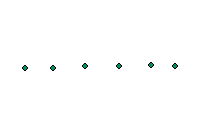

In [30]:
object_point_srvc_const_ave = gis.content.search("DC_TrafficCameras_ConstitutionAve", item_type="feature service")[0]
object_point_srvc_const_ave

In [31]:
# Convert our existing service into a pandas dataframe
object_point_lyr_const_ave = object_point_srvc_const_ave.layers[0]
obj_fset_const_ave = object_point_lyr_const_ave.query()  #querying without any conditions returns all the features
obj_df_const_ave = obj_fset_const_ave.df
constitutionave_names_list = obj_df_const_ave.name.tolist()
ddot_constitutionave_df = ddot_df[ddot_df.name.isin(constitutionave_names_list)]

https://esrifederal.maps.arcgis.com/home/webmap/viewer.html?webmap=e081b389ac8d4bdb817c34dbe78a5fc4

## P3: Trend-setter

<Item title:"DC_TrafficCameras_HIST_ConstAve" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
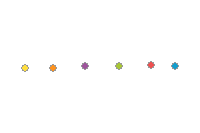

In [32]:
object_point_srvc = gis.content.search("DC_TrafficCameras_HIST_ConstAve", item_type="feature service")[0]
object_point_srvc

In [33]:
# Convert our existing service into a pandas dataframe
object_point_lyr = object_point_srvc.layers[0]
obj_fset = object_point_lyr.query()  #querying without any conditions returns all the features
obj_df = obj_fset.df
obj_df.head()

,F__OBJECTID,OBJECTID,attribute_0,content,createdAt,description,latitude,longitude,name,observation_time,...,recording_time,rt_bicycle_count,rt_bus_count,rt_car_count,rt_motorcycle_count,rt_object_count,rt_pedestrian_count,rt_truck_count,rt_vehicle_count,SHAPE
0,1,1,None,{'halfJpeg': 'http://ie.trafficland.com/v1.0/2...,1410450964690,None,38.892306,-77.028276,12th St @ Constitution Ave,NaN,...,None,0,0,0,0,0,0,0,0,"{'x': -8574748, 'y': 4706257}"
1,2,2,None,{'halfJpeg': 'http://ie.trafficland.com/v1.0/2...,1410450997585,None,38.892269,-77.024097,9th St @ Constitution Ave,NaN,...,None,0,0,0,0,0,0,0,0,"{'x': -8574283, 'y': 4706252}"
2,3,3,None,{'halfJpeg': 'http://ie.trafficland.com/v1.0/2...,1410451320851,None,38.892212,-77.033831,Constitution Ave @ 15th St,NaN,...,None,0,0,0,0,0,0,0,0,"{'x': -8575367, 'y': 4706244}"
3,4,4,None,{'halfJpeg': 'http://ie.trafficland.com/v1.0/2...,1410454639501,None,38.892221,-77.039654,Constitution Ave @ 17th St,NaN,...,None,0,0,0,0,0,0,0,0,"{'x': -8576015, 'y': 4706245}"
4,5,5,None,{'halfJpeg': 'http://ie.trafficland.com/v1.0/2...,1410454655458,None,38.891985,-77.049949,Constitution Ave @ 23rd St,NaN,...,None,0,0,0,0,0,0,0,0,"{'x': -8577161, 'y': 4706211}"


With auto-refresh of source JSON

In [36]:
with detection_graph.as_default():
    
    with tf.Session(graph=detection_graph) as sess:
        
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for refresh_iteration in range(10):
            print("Refresh iteration {0}...".format(str(refresh_iteration)))
            
            # TrafficLand API source JSON
            source_json = r"http://api.trafficland.com/v1.5/json/video_feeds?system=ddot&key=1594c8892d7fbd18181a8a6a44958b28"
            df = pd.read_json(source_json)
            ddot_df = df.loc[df.provider == 'DDOT']
            ddot_constitutionave_df = ddot_df[ddot_df.name.isin(constitutionave_names_list)]
            
            for iteration in range(100):
                print("Iteration: {0} of {1}".format(str(iteration), str(100)))

                for ix, row in enumerate(ddot_constitutionave_df.iterrows()):

                    # Retrieve camera information
                    camera_jpeg_url = ddot_constitutionave_df.iloc[ix]['content']['hugeJpeg']
                    camera_name = ddot_constitutionave_df.iloc[ix]['name']
                    camera_id = ddot_constitutionave_df.iloc[ix]['publicId']

                    # Retrieve the camera image
                    camera_response = requests.get(camera_jpeg_url)

                    image = Image.open(BytesIO(camera_response.content))
                    image_np = load_image_into_numpy_array(image)
                    image_np_expanded = np.expand_dims(image_np, axis=0)

                    (boxes, scores, classes, num) = sess.run(
                          [detection_boxes, detection_scores, detection_classes, num_detections],
                          feed_dict={image_tensor: image_np_expanded})

                    vis_util.visualize_boxes_and_labels_on_image_array(
                          image_np,
                          np.squeeze(boxes),
                          np.squeeze(classes).astype(np.int32),
                          np.squeeze(scores),
                          category_index,
                          use_normalized_coordinates=True,
                          line_thickness=8)

                    car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count = object_counter(np.squeeze(classes).astype(np.int32), np.squeeze(scores))
                    vehicle_count = car_count + motorcycle_count + bus_count + truck_count
                    total_count = vehicle_count + bicycle_count + people_count

                    # Retrieve the feature from the feature layer to update
                    obj_fset = object_point_lyr.query(where="""name = '"""+camera_name+"""'""")  
                    all_features = obj_fset.features
                    original_feature = all_features[0]

                    features_to_be_added = []
                    new_feature = deepcopy(original_feature)

                    new_feature.attributes['rt_object_count'] = total_count
                    new_feature.attributes['rt_vehicle_count'] = vehicle_count
                    new_feature.attributes['rt_car_count'] = car_count
                    new_feature.attributes['rt_bus_count'] = bus_count
                    new_feature.attributes['rt_truck_count'] = truck_count
                    new_feature.attributes['rt_motorcycle_count'] = motorcycle_count
                    new_feature.attributes['rt_pedestrian_count'] = people_count
                    new_feature.attributes['rt_bicycle_count'] = bicycle_count
                    new_feature.attributes['recording_id'] = "Cam{0}_{1}".format(str(ix),
                                                                                 str(datetime.now().strftime("%m%d%y_%H%M%S")))
                    new_feature.attributes['observation_time'] = datetime.now().strftime("%m/%d/%y %H:%M:%S")

                    #add this to the list of features to be updated
                    features_to_be_added.append(new_feature)

                    object_point_lyr.edit_features(adds = features_to_be_added) 

Refresh iteration 0...
Iteration: 0 of 100
Iteration: 1 of 100
Iteration: 2 of 100
Iteration: 3 of 100
Iteration: 4 of 100
Iteration: 5 of 100
Iteration: 6 of 100
Iteration: 7 of 100
Iteration: 8 of 100
Iteration: 9 of 100
Iteration: 10 of 100
Iteration: 11 of 100
Iteration: 12 of 100
Iteration: 13 of 100
Iteration: 14 of 100
Iteration: 15 of 100
Iteration: 16 of 100
Iteration: 17 of 100
Iteration: 18 of 100
Iteration: 19 of 100
Iteration: 20 of 100
Iteration: 21 of 100
Iteration: 22 of 100
Iteration: 23 of 100
Iteration: 24 of 100
Iteration: 25 of 100
Iteration: 26 of 100
Iteration: 27 of 100
Iteration: 28 of 100
Iteration: 29 of 100
Iteration: 30 of 100
Iteration: 31 of 100
Iteration: 32 of 100
Iteration: 33 of 100
Iteration: 34 of 100
Iteration: 35 of 100
Iteration: 36 of 100
Iteration: 37 of 100
Iteration: 38 of 100
Iteration: 39 of 100
Iteration: 40 of 100
Iteration: 41 of 100
Iteration: 42 of 100
Iteration: 43 of 100
Iteration: 44 of 100
Iteration: 45 of 100
Iteration: 46 of 100


Iteration: 88 of 100
Iteration: 89 of 100
Iteration: 90 of 100
Iteration: 91 of 100
Iteration: 92 of 100
Iteration: 93 of 100
Iteration: 94 of 100
Iteration: 95 of 100
Iteration: 96 of 100
Iteration: 97 of 100
Iteration: 98 of 100
Iteration: 99 of 100
Refresh iteration 4...
Iteration: 0 of 100
Iteration: 1 of 100
Iteration: 2 of 100
Iteration: 3 of 100
Iteration: 4 of 100
Iteration: 5 of 100
Iteration: 6 of 100
Iteration: 7 of 100
Iteration: 8 of 100
Iteration: 9 of 100
Iteration: 10 of 100
Iteration: 11 of 100
Iteration: 12 of 100
Iteration: 13 of 100
Iteration: 14 of 100
Iteration: 15 of 100
Iteration: 16 of 100
Iteration: 17 of 100
Iteration: 18 of 100
Iteration: 19 of 100
Iteration: 20 of 100
Iteration: 21 of 100
Iteration: 22 of 100
Iteration: 23 of 100
Iteration: 24 of 100
Iteration: 25 of 100
Iteration: 26 of 100
Iteration: 27 of 100
Iteration: 28 of 100
Iteration: 29 of 100
Iteration: 30 of 100
Iteration: 31 of 100
Iteration: 32 of 100
Iteration: 33 of 100
Iteration: 34 of 100


KeyboardInterrupt: 